<a href="https://colab.research.google.com/github/HR0262/PCMCI-in-commuter-trian/blob/main/PCMCI-0427.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tigramite
!pip install dcor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.6/309.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.2 MB/s eta 0:00:00


In [2]:
# Imports
import numpy as np
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import pandas as pd
import pickle
import networkx as nx

In [3]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI
from tigramite.jpcmciplus import JPCMCIplus

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS
from tigramite.independence_tests.gpdc import GPDC

from tigramite.plotting import plot_time_series_graph
from tigramite.plotting import plot_graph

In [4]:
df = pd.read_csv(r"/content/data_4041_20230427.csv", index_col=0)
#df.drop(columns=['Unnamed: 0'], inplace=True)
df.index.name = None
display(df)

,1_Tumba,2_Tullinge,3_Flemingsberg,4_Huddinge,5_Stuvsta,6_Älvsjö,7_Årstaberg,8_Stockholms södra,9_Stockholm City,10_Stockholm Odenplan,11_Solna,12_Ulriksdal,13_Helenelund,14_Sollentuna,15_Häggvik,16_Norrviken,17_Rotebro,18_Upplands Väsby,Departure_Time
0_41,0.0,-2.0,38.0,29.0,-10.0,-42.0,20.0,13.0,28.0,69.0,27.0,-17.0,37.0,21.0,-33.0,56.0,23.0,6.0,21720.0
1_40,0.0,-3.0,10.0,0.0,-20.0,-43.0,35.0,43.0,52.0,68.0,35.0,-3.0,20.0,8.0,-50.0,-10.0,-24.0,-3.0,22200.0
2_41,0.0,-77.0,-66.0,-70.0,-100.0,-125.0,-67.0,-71.0,-52.0,1.0,-31.0,-70.0,-33.0,-44.0,-94.0,-7.0,-34.0,-41.0,22620.0
3_41,0.0,-6.0,-2.0,-2.0,-18.0,-64.0,-13.0,3.0,32.0,19.0,-6.0,-39.0,9.0,14.0,-42.0,27.0,-1.0,-5.0,23100.0
4_41,0.0,-19.0,-18.0,-29.0,-48.0,-75.0,-23.0,-18.0,-4.0,4.0,-32.0,-53.0,-31.0,-53.0,-88.0,0.0,-23.0,-27.0,23520.0
5_40,0.0,4.0,109.0,117.0,93.0,49.0,62.0,70.0,95.0,62.0,25.0,-9.0,-1.0,-12.0,-70.0,-57.0,-83.0,-101.0,24000.0
6_41,0.0,-9.0,-5.0,-13.0,-32.0,-69.0,0.0,10.0,34.0,57.0,50.0,353.0,373.0,357.0,307.0,375.0,352.0,363.0,24900.0
7_41,0.0,10.0,42.0,60.0,56.0,27.0,48.0,89.0,141.0,169.0,165.0,158.0,187.0,188.0,164.0,236.0,208.0,203.0,25320.0
8_40,0.0,-18.0,-10.0,52.0,21.0,-36.0,185.0,181.0,199.0,276.0,238.0,201.0,200.0,183.0,136.0,125.0,118.0,116.0,25800.0
9_41,0.0,-56.0,-53.0,-63.0,-87.0,-125.0,23.0,54.0,74.0,139.0,153.0,124.0,140.0,122.0,51.0,104.0,101.0,112.0,26220.0


In [5]:
df_delay = df.drop(columns=["Departure_Time"])

# PCMCI 用车站作为列，车次作为行 分析

分析车站之间的因果关系

In [6]:
dataframe = pp.DataFrame(data = df_delay.values, var_names = df_delay.columns)

In [7]:
parcorr = ParCorr(significance='analytic')
robust_parcorr=RobustParCorr(significance='analytic')
gpdc = GPDC()

# 早高峰
# 筛选前后
cond_ind_test=gpdc #非线性关系
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=cond_ind_test,
    verbosity=1)
tau_max = 3 #评价影响几个车次，1-10个数多少
pc_alpha = 0.05
pcmci.verbosity = 1

# results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)
results = pcmci.run_pcmci(tau_min=0, tau_max=tau_max, pc_alpha=None,alpha_level=0.05)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = gp_dc
tau_min = 1
tau_max = 3
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1




/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarnin


## Resulting lagged parent (super)sets:

    Variable 1_Tumba has 0 link(s):
    [pc_alpha = 0.05]

    Variable 2_Tullinge has 2 link(s):
    [pc_alpha = 0.3]
        (10_Stockholm Odenplan -3): max_pval = 0.23200, |min_val| =  0.447
        (8_Stockholms södra -1): max_pval = 0.28400, |min_val| =  0.429

    Variable 3_Flemingsberg has 5 link(s):
    [pc_alpha = 0.5]
        (17_Rotebro -3): max_pval = 0.27600, |min_val| =  0.433
        (7_Årstaberg -2): max_pval = 0.36600, |min_val| =  0.407
        (8_Stockholms södra -2): max_pval = 0.41000, |min_val| =  0.398
        (4_Huddinge -1): max_pval = 0.41800, |min_val| =  0.394
        (9_Stockholm City -1): max_pval = 0.43800, |min_val| =  0.390

    Variable 4_Huddinge has 5 link(s):
    [pc_alpha = 0.5]
        (17_Rotebro -1): max_pval = 0.20200, |min_val| =  0.463
        (18_Upplands Väsby -1): max_pval = 0.30200, |min_val| =  0.426
        (18_Upplands Väsby -3): max_pval = 0.37600, |min_val| =  0.405
        (11_Solna -3): ma

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:


## Significant links at alpha = 0.05:

    Variable 1_Tumba has 0 link(s):

    Variable 2_Tullinge has 3 link(s):
        (3_Flemingsberg  0): pval = 0.00000 | val =  0.879 | unoriented link
        (8_Stockholms södra -1): pval = 0.02000 | val =  0.601
        (4_Huddinge  0): pval = 0.04400 | val =  0.570 | unoriented link

    Variable 3_Flemingsberg has 3 link(s):
        (2_Tullinge  0): pval = 0.00000 | val =  0.879 | unoriented link
        (16_Norrviken -3): pval = 0.03000 | val =  0.589
        (4_Huddinge -1): pval = 0.05000 | val =  0.561

    Variable 4_Huddinge has 6 link(s):
        (5_Stuvsta  0): pval = 0.00000 | val =  0.862 | unoriented link
        (8_Stockholms södra  0): pval = 0.00400 | val =  0.663 | unoriented link
        (7_Årstaberg -2): pval = 0.01000 | val =  0.641
        (11_Solna -3): pval = 0.01600 | val =  0.614
        (2_Tullinge  0): pval = 0.04400 | val =  0.570 | unoriented link
        (10_Stockholm Odenplan  0): pval = 0.04800 | val =  0.562 |

p_matrix[i, j, tau]	vs val_matrix[i, j, tau]

统计检验的 p 值（显著性），条件独立性检验的 统计量（强度），❌ 越小越显著，< 0.05 常用于筛选， 用来判断是否显著、有因果边

val_matrix[i, j, tau]，条件独立性检验的 统计量（强度），✅ 越大（或绝对值大）说明依赖更强，用来排序因果边强弱

用法p < 0.05 筛选显著因果边。用 p_matrix 做初步筛选，再用 val_matrix 判断因果强度。

# p_matrix 筛选 并计数不同tau下连接数



In [8]:
print(results.keys())

p_matrix=results['p_matrix']
print('p_matrix:')
print(p_matrix.shape)
array_1d_p_matrix = p_matrix.reshape(-1)
print(array_1d_p_matrix.shape)
print(len(array_1d_p_matrix[array_1d_p_matrix<0.05]))
graph=results['graph']
print('graph:')
print(graph.shape)
array_1d_graph = graph.reshape(-1)
print(array_1d_graph.shape)
print(len(array_1d_graph[array_1d_graph!='']))

dict_keys(['graph', 'p_matrix', 'val_matrix', 'conf_matrix'])
p_matrix:
(18, 18, 4)
(1296,)
154
graph:
(18, 18, 4)
(1296,)
158


对p_matrix进行筛选

后续站点不会对当前站点造成影响，当前站点的后续车次不会对当前造成影响

p_matrix[i,j,tau]<alpha_level 表示i站点在tau步前对j站点有因果影响

count数不同tau下的因果链接数量

In [51]:
p_matrix_clean = results['p_matrix'].copy()  # 不直接修改原始数据，避免污染

# 遍历所有 target, source, tau 组合
num_vars = p_matrix_clean.shape[0]
tau_max_plus1 = p_matrix_clean.shape[2]
print(p_matrix_clean.shape)
count=[0]*(tau_max+1)
alpha_level=0.05

for i in range(num_vars):       # target
    for j in range(num_vars):   # source
        for tau in range(tau_max_plus1):
            target_idx = j+1
            source_idx = i+1

            # 如果后续站点影响当前站点，则置为空字符串
            if source_idx > target_idx+tau:
              p_matrix_clean[i, j, tau] = 1
            elif p_matrix_clean[i, j, tau]<=alpha_level:
              count[tau]+=1


array_1d_p_matrix_clean = p_matrix_clean.reshape(-1)
print(array_1d_p_matrix_clean.shape)
print(len(array_1d_p_matrix_clean[array_1d_p_matrix_clean<=0.05]))
print(count)

(18, 18, 4)
(1296,)
77
[63, 6, 5, 3]


# 可视化部分

边上的数字是前n个站点的延误对当前站点的因果影响

节点颜色的深浅代表auto-MCI values，表明了过去车次对站点的因果影响

边的颜色深浅代表cross-MCI values，表明了其他站点对该站点的因果影响

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

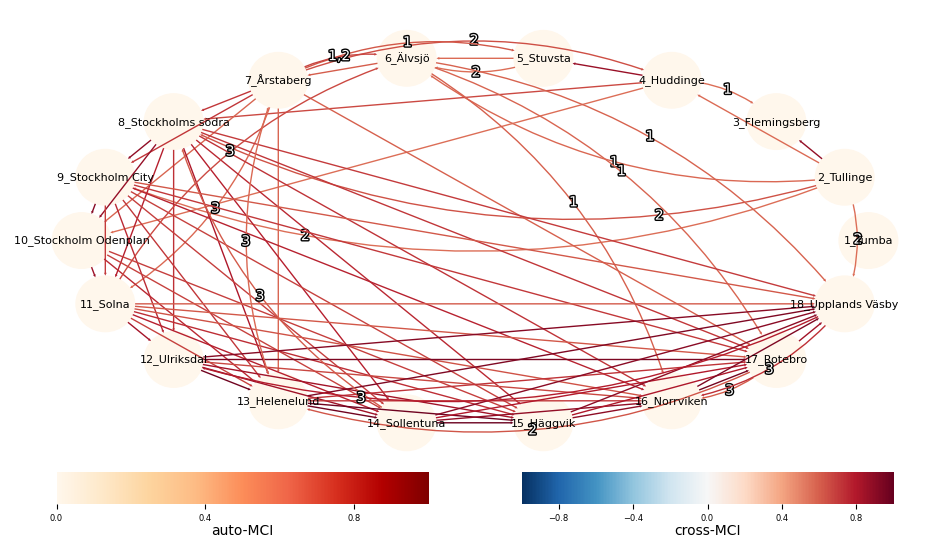

In [31]:
# 需要跟前面节点进行筛选配合，筛选p_matrix，val_matrix

# 设置显著性水平
alpha_level = 0.05

# 从 p_matrix 生成布尔型因果图
graph = pcmci.get_graph_from_pmatrix(
    p_matrix=p_matrix_clean,
    alpha_level=alpha_level,
    tau_min=0,
    tau_max=tau_max
)
# 绘图
plot_graph(
    graph=graph,
    val_matrix=results['val_matrix'],             # 测试统计值，通常是偏相关或其他统计量
    var_names=dataframe.var_names,                # 变量名称（你自己的时间序列名称）
    link_colorbar_label='cross-MCI',                # 显示边的颜色表示的含义（例如：偏相关系数）
    figsize=(12, 6),                              # 图像大小
    alpha=1.0,                                    # 图形的透明度
    arrow_linewidth=1.0,                          # 箭头的线宽
    node_size=0.3,                                # 节点大小
    curved_radius=0.2,                            # 边的弯曲度
    label_fontsize=10,                            # 标签字体大小
    node_label_size=8,                           # 节点标签字体大小
    cmap_edges='RdBu_r',                          # 边的颜色映射（红蓝渐变）
    cmap_nodes='OrRd',                            # 节点的颜色映射
    show_colorbar=True,                           # 显示颜色条
    show_autodependency_lags=True,                # 显示自依赖延迟
    vmin_edges=-1,                                # 边的颜色条范围
    vmax_edges=1.0,                               # 边的颜色条范围
    vmin_nodes=0,                                 # 节点颜色条范围
    vmax_nodes=1.0                                # 节点颜色条范围
)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

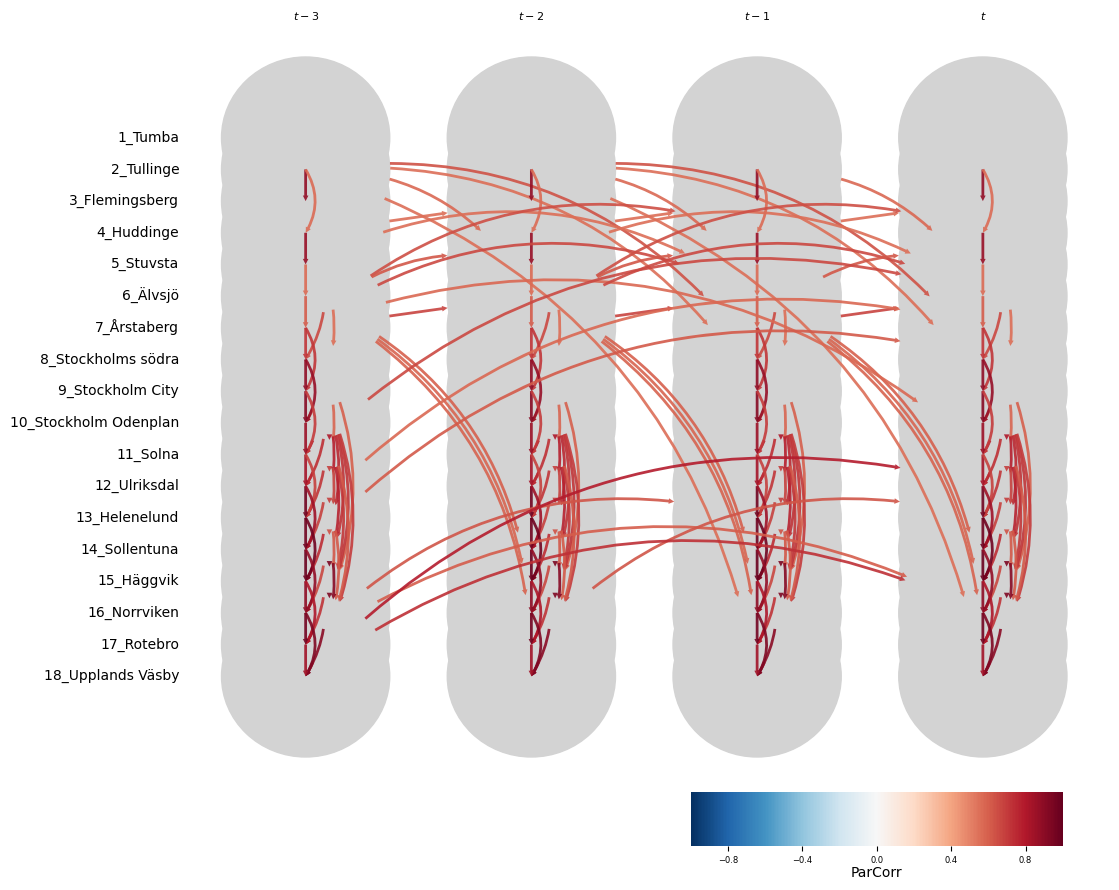

In [32]:
# 设置显著性水平
alpha_level = 0.05

# 从 p_matrix 生成布尔型因果图
graph = pcmci.get_graph_from_pmatrix(
    p_matrix=p_matrix_clean,
    alpha_level=alpha_level,
    tau_min=0,
    tau_max=tau_max
)

# 绘图
plot_time_series_graph(
    graph=graph,
    val_matrix=results['val_matrix'],             # 偏相关值/测试统计值
    var_names=dataframe.var_names,                # 节点名字
    link_colorbar_label='ParCorr',                # 显示偏相关值的图例
    figsize=(12, 10),                              # 图像大小
    alpha=0.9,                                    # 边透明度
    arrow_linewidth=2.0,                          # 箭头线宽
    node_size=0.3,                                # 节点大小
    curved_radius=0.3                             # 边曲率
)

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

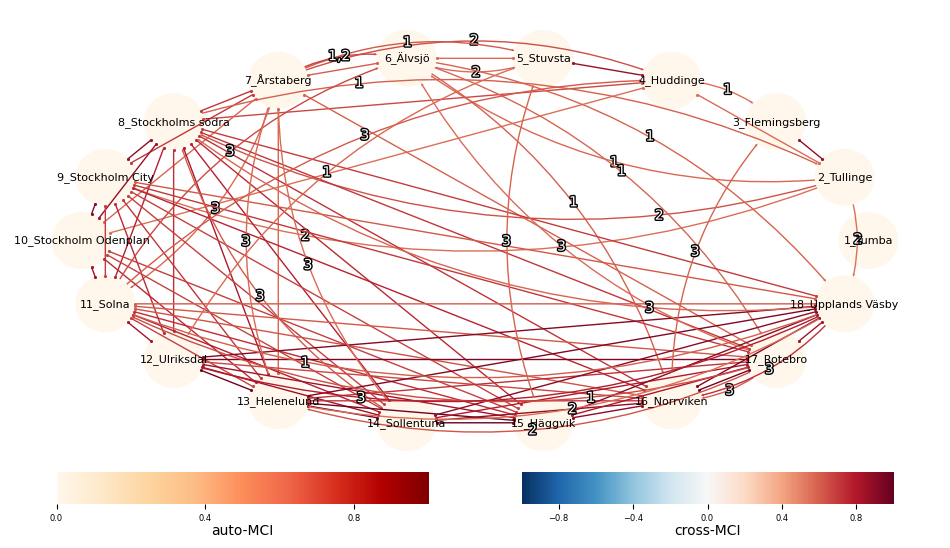

In [13]:
# 从 p_matrix 生成布尔型因果图
graph = pcmci.get_graph_from_pmatrix(
    p_matrix=results['p_matrix'],
    alpha_level=alpha_level,
    tau_min=0,
    tau_max=tau_max
)
# 绘图
plot_graph(
    graph=graph,
    val_matrix=results['val_matrix'],             # 测试统计值，通常是偏相关或其他统计量
    var_names=dataframe.var_names,                # 变量名称（你自己的时间序列名称）
    link_colorbar_label='cross-MCI',                # 显示边的颜色表示的含义（例如：偏相关系数）
    figsize=(12, 6),                              # 图像大小
    alpha=1.0,                                    # 图形的透明度
    arrow_linewidth=1.0,                          # 箭头的线宽
    node_size=0.3,                                # 节点大小
    curved_radius=0.2,                            # 边的弯曲度
    label_fontsize=10,                            # 标签字体大小
    node_label_size=8,                           # 节点标签字体大小
    cmap_edges='RdBu_r',                          # 边的颜色映射（红蓝渐变）
    cmap_nodes='OrRd',                            # 节点的颜色映射
    show_colorbar=True,                           # 显示颜色条
    show_autodependency_lags=True,                # 显示自依赖延迟
    vmin_edges=-1,                                # 边的颜色条范围
    vmax_edges=1.0,                               # 边的颜色条范围
    vmin_nodes=0,                                 # 节点颜色条范围
    vmax_nodes=1.0                                # 节点颜色条范围
)

# 复杂网络

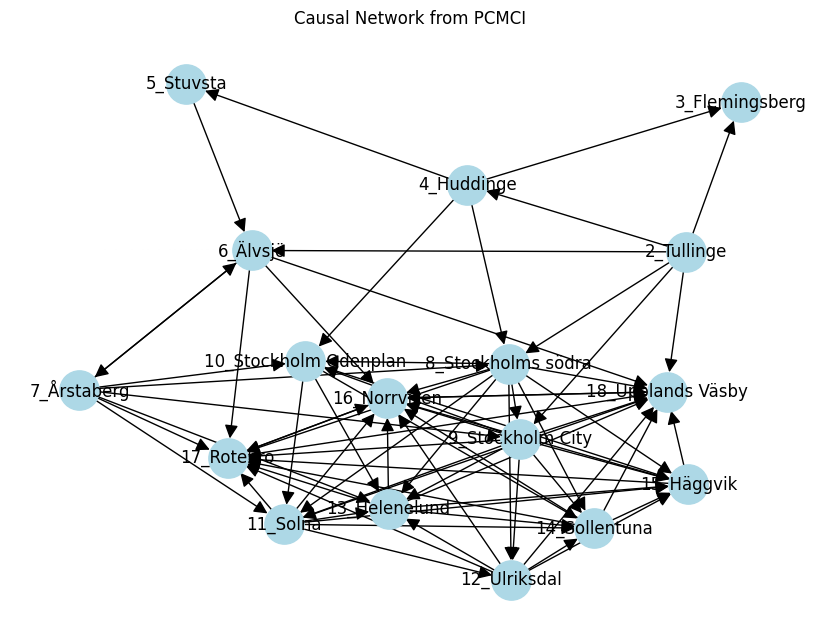

节点个数: 17
节点名称： ['2_Tullinge', '3_Flemingsberg', '4_Huddinge', '6_Älvsjö', '8_Stockholms södra', '9_Stockholm City', '18_Upplands Väsby', '5_Stuvsta', '10_Stockholm Odenplan', '7_Årstaberg', '16_Norrviken', '17_Rotebro', '11_Solna', '13_Helenelund', '12_Ulriksdal', '14_Sollentuna', '15_Häggvik']


In [52]:
# 假设变量名是按顺序排布的
variable_names = df_delay.columns  # 填入你的站点名列表
n_vars = len(variable_names)
max_lag = graph.shape[2]  # tau_max + 1

r_pmatrix=results['p_matrix']
p_matrix_clean

# 创建一个有向图
G = nx.DiGraph()

# 添加因果边：从变量 j (过去时刻 t-τ) 到变量 i (当前时刻 t)
for i in range(n_vars):
    for j in range(n_vars):
        for tau in range(0, max_lag):  # tau=0表示同步，通常不用于因果分析
            if p_matrix_clean[i, j, tau]<=alpha_level:
                # 添加从 i 到 j 的有向边（可以标注 lag 信息）
                G.add_edge(variable_names[i], variable_names[j], lag=tau)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
# pos = nx.spring_layout(G, seed=42)  # 或 nx.kamada_kawai_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw(G, pos, with_labels=True, node_size=800, node_color='lightblue', arrowsize=20)
plt.title("Causal Network from PCMCI")
plt.show()

num_nodes = G.number_of_nodes()
print("节点个数:", num_nodes)
print("节点名称：", list(G.nodes()))

In [53]:
in_degrees = dict(G.in_degree())
top_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

out_degrees = dict(G.out_degree())
top_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

betweenness = nx.betweenness_centrality(G)
top_bet = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

closeness = nx.closeness_centrality(G)
top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:5]

pagerank = nx.pagerank(G)  #节点重要性
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

# is_strongly_connected = nx.is_strongly_connected(G)
# top_strongly_connected = sorted(is_strongly_connected.items(), key=lambda x: x[1], reverse=True)[:10]

strongly_connected_components = list(nx.strongly_connected_components(G))
top_strongly_connected_components = sorted(strongly_connected_components, key=lambda x: len(x), reverse=True)[:5]

print(top_in)
print(top_out)
print(top_bet)
print(top_closeness)
print(top_pagerank)
print(top_strongly_connected_components)

[('18_Upplands Väsby', 11), ('16_Norrviken', 10), ('17_Rotebro', 10), ('15_Häggvik', 7), ('13_Helenelund', 6)]
[('8_Stockholms södra', 10), ('9_Stockholm City', 9), ('7_Årstaberg', 7), ('11_Solna', 7), ('2_Tullinge', 6)]
[('7_Årstaberg', 0.06666666666666667), ('6_Älvsjö', 0.06215277777777777), ('8_Stockholms södra', 0.053958333333333344), ('9_Stockholm City', 0.024791666666666667), ('11_Solna', 0.017847222222222223)]
[('18_Upplands Väsby', 0.7401315789473685), ('16_Norrviken', 0.703125), ('17_Rotebro', 0.703125), ('15_Häggvik', 0.44999999999999996), ('13_Helenelund', 0.41666666666666663)]
[('16_Norrviken', 0.33226180982533965), ('18_Upplands Väsby', 0.25665573380948886), ('17_Rotebro', 0.18038166295956726), ('15_Häggvik', 0.028099416982188895), ('14_Sollentuna', 0.023174755535791167)]
[{'17_Rotebro', '16_Norrviken', '18_Upplands Väsby'}, {'6_Älvsjö', '7_Årstaberg'}, {'3_Flemingsberg'}, {'15_Häggvik'}, {'14_Sollentuna'}]


In [54]:
def strict_directed_closeness_centrality(G):
    closeness = {}
    N = len(G)

    for node in G.nodes:
        # 仅使用有向边计算最短路径长度
        path_lengths = nx.single_source_shortest_path_length(G, node)

        # 只考虑可达的其他节点（不包含自身）
        reachable_nodes = len(path_lengths) - 1

        if reachable_nodes > 0:
            total_distance = sum(length for target, length in path_lengths.items() if target != node)
            closeness[node] = reachable_nodes / total_distance
        else:
            # 不可达任何其他节点，closeness 为 0
            closeness[node] = 0.0

    return closeness
strict_closeness = strict_directed_closeness_centrality(G)
top_closeness_s = sorted(strict_closeness.items(), key=lambda x: x[1], reverse=True)[:5]
print(top_closeness_s)

[('8_Stockholms södra', 1.0), ('9_Stockholm City', 1.0), ('16_Norrviken', 1.0), ('17_Rotebro', 1.0), ('11_Solna', 1.0)]


In [56]:
betweenness = nx.betweenness_centrality(G, normalized=True)
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
#节点的介数中心性高意味着它在其他节点之间的信息传递中处于中间位置，可能控制信息流。

# 取最大强连通子图
largest_scc = max(nx.strongly_connected_components(G), key=len)
G_scc = G.subgraph(largest_scc)
eigenvector = nx.eigenvector_centrality_numpy(G_scc)
top_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:5]

hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)
top_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:5]
top_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:5]
#节点的 hubs 中心性越高，表示它与很多其他节点有连接，并且可能在信息传播中起到重要作用。
#节点的 authorities 中心性越高，表示它接收了来自其他节点的很多连接，可能是信息的接收点。

reachability = {}
for node in G.nodes:
    reachable = nx.descendants(G, node)  # 方向性！从 node 出发能到达谁
    reachability[node] = len(reachable)
top_reachability = sorted(reachability.items(), key=lambda x: x[1], reverse=True)[:5]
#节点的可达性越高，表示它可以影响到更多的节点，可能是一个信息源或传播中心。


largest_scc = max(nx.strongly_connected_components(G), key=len)
subgraph = G.subgraph(largest_scc)
avg_path_length = nx.average_shortest_path_length(subgraph)
print(f"Average Path Length (on largest strongly connected component): {avg_path_length:.3f}")
#是图中节点之间的平均最短路径长度。这里计算的是 最大强连通分量（SCC）中的节点对之间的平均最短路径长度。值 1.167 表示在最大强连通分量中，节点间的平均路径长度为 1.167 步。

cascade_potential = {}
for node in G.nodes:
    cascade_potential[node] = len(nx.descendants(G, node))
top_cascade = sorted(cascade_potential.items(), key=lambda x: x[1], reverse=True)[:5]
#节点的 cascade potential 越高，表示它有更大的潜力在网络中引发信息传播


def print_top(title, data):
    print(f"\nTop 5 {title}:")
    for node, value in data:
        print(f"Node {node}: {value:.4f}")

print_top("Betweenness", top_betweenness)
print_top("Eigenvector", top_eigenvector)
print_top("Hubs", top_hubs)
print_top("Authorities", top_authorities)
print_top("Reachability", top_reachability)
print_top("Cascade Potential", top_cascade)

Average Path Length (on largest strongly connected component): 1.167

Top 5 Betweenness:
Node 7_Årstaberg: 0.0667
Node 6_Älvsjö: 0.0622
Node 8_Stockholms södra: 0.0540
Node 9_Stockholm City: 0.0248
Node 11_Solna: 0.0178

Top 5 Eigenvector:
Node 18_Upplands Väsby: 0.6479
Node 16_Norrviken: 0.6479
Node 17_Rotebro: 0.4004

Top 5 Hubs:
Node 8_Stockholms södra: 0.1312
Node 9_Stockholm City: 0.1261
Node 11_Solna: 0.1100
Node 12_Ulriksdal: 0.1015
Node 13_Helenelund: 0.0880

Top 5 Authorities:
Node 18_Upplands Väsby: 0.1429
Node 17_Rotebro: 0.1411
Node 16_Norrviken: 0.1342
Node 15_Häggvik: 0.1137
Node 14_Sollentuna: 0.1014

Top 5 Reachability:
Node 2_Tullinge: 16.0000
Node 4_Huddinge: 15.0000
Node 5_Stuvsta: 13.0000
Node 6_Älvsjö: 12.0000
Node 7_Årstaberg: 12.0000

Top 5 Cascade Potential:
Node 2_Tullinge: 16.0000
Node 4_Huddinge: 15.0000
Node 5_Stuvsta: 13.0000
Node 6_Älvsjö: 12.0000
Node 7_Årstaberg: 12.0000
